In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.dimensionality import BaseDimensionalityReduction
from sklearn.feature_extraction.text import CountVectorizer
from umap import UMAP
from hdbscan import HDBSCAN
from sentence_transformers import SentenceTransformer

In [2]:
df_02 = pd.read_csv('data/stemmed_merged_kubu_02.csv')

In [3]:
# Enhanced stopwords list for presidential election dataset
indo_stopwords = [
    # Basic Indonesian stopwords (keep these)
    "yang", "dan", "di", "dengan", "untuk", "dari", "ke", "pada", "ini", "itu",
    "atau", "ada", "juga", "dalam", "saya", "kamu", "anda", "mereka", "kita", "kami",
    "dia", "nya", "adalah", "akan", "oleh", "seperti", "telah", "sudah", "bisa", "dapat",
    "tidak", "tak", "jangan", "ya", "via", "yg", "dgn", "utk", "dr", "pd", "dlm", "sdh", "tdk",
    
    # Common tweet/social media terms
    "via", "rt", "dm", "pm", "cc", "wkwk", "haha", "woi", "hey", "ah", "eh", "oh", "hmm",
    "uwu", "btw", "omg", "lol", "min", "admin", "hehe", "wkwkwk", "awokawok", "hahaha",

        # Locations 
    "indonesia", "jakarta", "jawa", "barat", "timur", "tengah", "sumatra", "bali", "aceh", "selatan", 
    "utara", "kota", "desa", "daerah", "wilayah", "provinsi", "kabupaten", "negara", "republik",

    "mas", "pak", "bu", "bapak", "ibu", "om", "tante", "mbak", "bro", "sis", "bang", "abang",
    "saudara", "laki", "wanita", "kak", "adek", "adik", "kakak", "anak", "bung",

    #candidate names
    "prabowo", "jokowi", "gibran", "subianto", "rakabuming", "anies", "ganjar",
    
]

In [4]:

vectorizer = CountVectorizer(
    stop_words=indo_stopwords,
    ngram_range=(1, 3),  # Keep bigrams and trigrams for political phrases
    min_df=5,            # Lower threshold to capture more specific topics
    max_df=0.7           # Stricter upper bound to remove very common terms
)

# Configure UMAP for better clustering of political content
umap_model = UMAP(
    n_neighbors=15,      # Smaller neighborhood for more specific clusters
    n_components=5,      
    min_dist=0.0,        # Adjusted for better separation
    metric='cosine',
    random_state=42
)

# More sensitive clustering for political topics
hdbscan_model = HDBSCAN(
    min_cluster_size=10,  # Smaller clusters to capture specific campaign themes
    min_samples=5,       # More lenient sample requirement
    metric='euclidean',
    cluster_selection_method='eom',
    prediction_data=True
)

# Improved c-TF-IDF weighting
ctfidf_model = ClassTfidfTransformer(
    reduce_frequent_words=True,
    bm25_weighting=True
)

embedding_model = SentenceTransformer(
    'distiluse-base-multilingual-cased-v1'
)

# Configure BERTopic for Indonesian political content
topic_model = BERTopic(
    language="multilingual",  # Keep multilingual for Indonesian
    calculate_probabilities=True,
    verbose=True,
    nr_topics=15,             # Reduced from 15 to get more focused topics
    min_topic_size=5,         # Smaller topics to capture campaign themes
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    ctfidf_model=ctfidf_model,
    vectorizer_model=vectorizer,
    embedding_model=embedding_model,
)


# Fit the model
topics, probs = topic_model.fit_transform(df_02['full_text'].tolist())

2025-05-22 19:25:04,222 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/2951 [00:00<?, ?it/s]

2025-05-22 19:25:19,207 - BERTopic - Embedding - Completed ✓
2025-05-22 19:25:19,208 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-05-22 19:26:16,727 - BERTopic - Dimensionality - Completed ✓
2025-05-22 19:26:16,728 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-05-22 22:02:41,757 - BERTopic - Cluster - Completed ✓
2025-05-22 22:02:41,758 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-05-22 22:02:43,611 - BERTopic - Representation - Completed ✓
2025-05-22 22:02:43,611 - BERTopic - Topic reduction - Reducing number of topics
2025-05-22 22:02:43,661 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-05-22 22:02:45,006 - BERTopic - Representation - Completed ✓
2025-05-22 22:02:45,011 - BERTopic - Topic reduction - Reduced number of topics from 910 to 15


In [5]:
# Define custom topic labels
topic_labels = {}
for topic_id in topic_model.get_topic_info()["Topic"]:
    if topic_id == -1:
        topic_labels[topic_id] = "Outlier"
        continue
        
    # Get top words for the topic
    words = [word for word, _ in topic_model.get_topic(topic_id)[:5]]
    
    # Map topics to specific campaign themes
    if any(term in words for term in ["palestina", "doa", "israel", "gaza"]):
        topic_labels[topic_id] = "Kampanye & Isu Palestina"
    elif any(term in words for term in ["aceh", "warga", "sambut", "bandara", "kedatagan"]):
        topic_labels[topic_id] = "Kunjungan Kampanye Aceh"
    elif any(term in words for term in ["sumbar", "sumatra", "safari", "bukittinggi"]):
        topic_labels[topic_id] = "Kampanye Sumatra Barat"
    elif any(term in words for term in ["adil", "makmur", "sejahtera", "ekonomi"]):
        topic_labels[topic_id] = "Visi Ekonomi & Kemakmuran"
    elif any(term in words for term in ["amin", "bismillah", "islam", "muslim"]):
        topic_labels[topic_id] = "Dukungan Religius"
    elif any(term in words for term in ["pesantren", "santri", "kiai", "ulama"]):
        topic_labels[topic_id] = "Dukungan Pesantren"
    elif any(term in words for term in ["konstitusi", "mk", "etik", "putus"]):
        topic_labels[topic_id] = "Polemik Mahkamah Konstitusi"
    elif any(term in words for term in ["solo", "surakarta", "wali"]):
        topic_labels[topic_id] = "Kinerja di Solo"
    elif any(term in words for term in ["elektabilitas", "unggul", "menang", "putar"]):
        topic_labels[topic_id] = "Elektabilitas & Polling"
    elif any(term in words for term in ["joget", "pidato", "debat", "acara"]):
        topic_labels[topic_id] = "Penampilan Pidato & Debat"
    else:
        # Use top 3 words as label for other topics
        topic_labels[topic_id] = " & ".join(words[:3])

# Apply custom labels
topic_model.set_topic_labels(topic_labels)

In [6]:
from wordcloud import WordCloud


Improved Topic Information:
   Topic  Count                                               Name  \
0     -1  31835       -1_pasang calon 02_calon 02_dukung 02_buzzer   
1      0  38598                  0_debat_02 menang_dukung 02_kayak   
2      1  15370                1_pilih presiden_survei_putar_kayak   
3      2   6642                        2_politik_raka_partai_juang   
4      3    916                        3_program_makan_gratis_food   
5      4    421           4_palestina_israel_profesional_abu janda   
6      5    172               5_ekonomi_tumbuh_infrastruktur_cipta   
7      6    123             6_online_direct message_message_direct   
8      7     85  7_sistem_alat utama sistem_utama sistem_alat u...   
9      8     82                   8_energi_hijau_positif_inspirasi   

                                  CustomName  \
0                                    Outlier   
1                  Penampilan Pidato & Debat   
2                    Elektabilitas & Polling   
3       

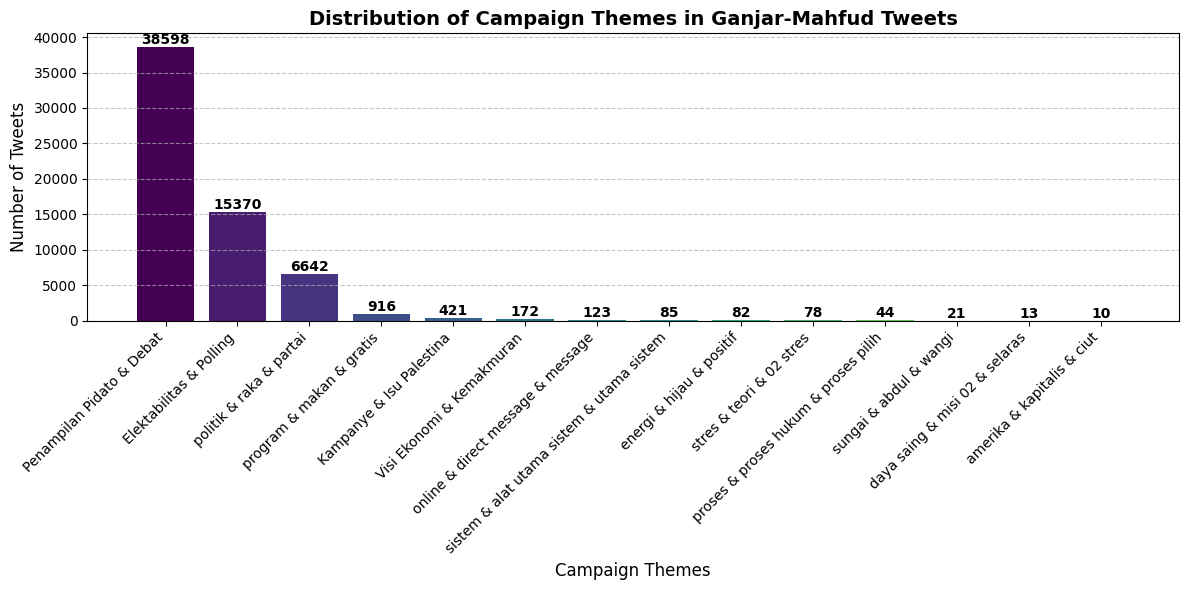

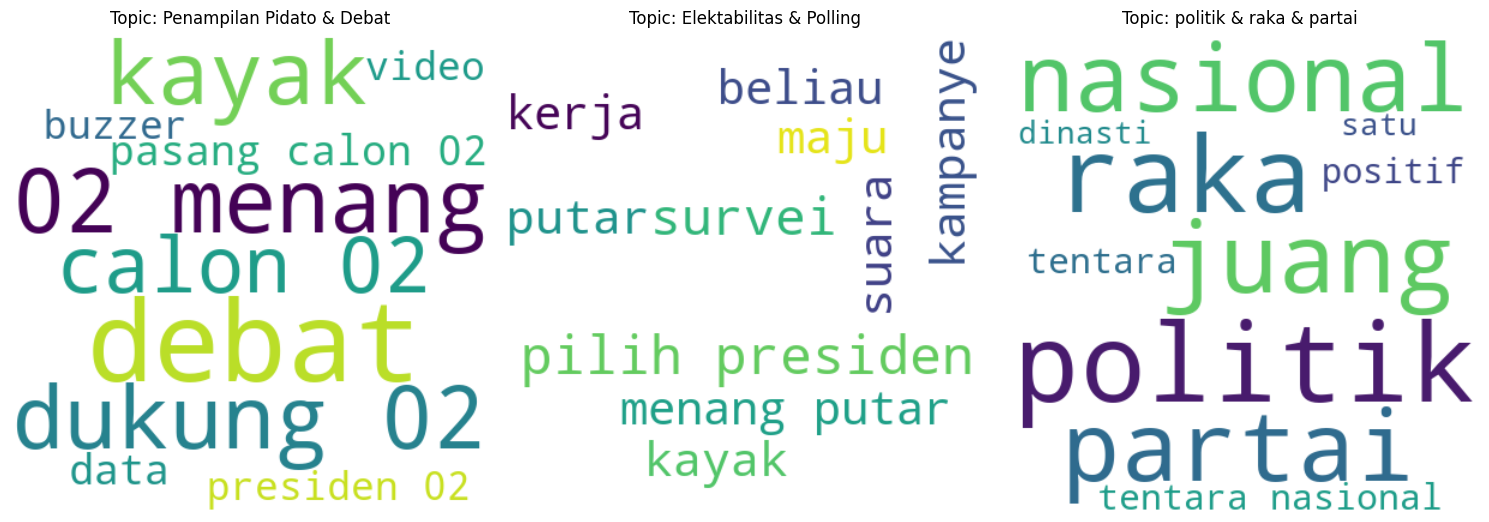

In [7]:
# Get the improved topic information
topic_info = topic_model.get_topic_info()
print("\nImproved Topic Information:")
print(topic_info.head(10))

# Print topics with their new labels
print("\nCampaign Themes for Ganjar-Mahfud:")
for index, row in topic_info.iterrows():
    if row["Topic"] != -1:  # Skip outlier topic
        topic_id = row["Topic"]
        words = [word[0] for word in topic_model.get_topic(topic_id)[:8]]
        print(f"Theme: {row['Name']}")
        print(f"Keywords: {', '.join(words)}")
        print(f"Document count: {row['Count']}")
        print("-" * 50)

# Create a topic distribution visualization
plt.figure(figsize=(12, 6))
topic_counts = topic_info[topic_info["Topic"] != -1]["Count"]
topic_names = [label for topic, label in topic_labels.items() if topic != -1][:len(topic_counts)]

# Plot with better color scheme
bars = plt.bar(topic_names, topic_counts, color=plt.cm.viridis(np.linspace(0, 1, len(topic_counts))))

# Add count labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
            f'{int(height)}', ha='center', va='bottom', fontweight='bold')

plt.xticks(rotation=45, ha="right")
plt.title("Distribution of Campaign Themes in Ganjar-Mahfud Tweets", fontsize=14, fontweight='bold')
plt.xlabel("Campaign Themes", fontsize=12)
plt.ylabel("Number of Tweets", fontsize=12)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Display interactive visualizations
intertopic_map = topic_model.visualize_topics()
display(intertopic_map)

# Create hierarchical clustering visualization
hierarchy = topic_model.visualize_hierarchy()
display(hierarchy)

# Create heatmap of topic similarities
heatmap = topic_model.visualize_heatmap()
display(heatmap)

# Create word clouds for top 3 topics
plt.figure(figsize=(15, 10))
for i, topic_id in enumerate(topic_info[topic_info['Topic'] != -1]['Topic'][:3]):
    plt.subplot(1, 3, i+1)
    
    # Get topic words and weights
    words = dict(topic_model.get_topic(topic_id)[:15])
    
    # Create and display wordcloud
    wordcloud = WordCloud(width=400, height=400, background_color='white', 
                          colormap='viridis', max_words=50).generate_from_frequencies(words)
    
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Topic: {topic_labels[topic_id]}", fontsize=12)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [8]:
from wordcloud import WordCloud
import seaborn as sns

In [9]:
# Create topic distribution from the existing topic_info
topic_distribution = topic_info.set_index("Topic")["Count"]

# Get representative documents for key campaign themes
print("\nRepresentative tweets for key campaign themes:")
key_topics = [t for t in topic_distribution.index if t != -1][:5]

for topic_id in key_topics:
    theme_name = topic_model.get_topic_info().loc[topic_model.get_topic_info()["Topic"] == topic_id, "Name"].values[0]
    print(f"\n--- Theme: {theme_name} ---")
    rep_docs = topic_model.get_representative_docs(topic_id)
    for i, doc in enumerate(rep_docs[:3]):
        print(f"{i+1}. {doc[:200]}...")


Representative tweets for key campaign themes:

--- Theme: 0_debat_02 menang_dukung 02_kayak ---
1. asyik nih calon presiden calon wakil presiden 02 mundur jabat takut kalah sih niat jabat presiden netral...
2. periksa in otak pakai mri error pilih calon pimpin calon ngakalin undang undang langgar konstitusi aneh visi misi apa solusi 02 makan siang gratis hilir...
3. pas voting isi x hina pndkg 02 maki sumber daya manusia rendah bla bla voting hasil selesai gambar hina sadar sih sumber daya manusia rendah hina bantu urus curang bilang komisi pemelihan hina...

--- Theme: 1_pilih presiden_survei_putar_kayak ---
1. prabowo pokok rusak incumbent fasilitas negara kampanye legal atur perintah calon presiden calon wakil presiden mundur...
2. undur calon presiden calon wakil presiden cuti kerja nusron wahid beliau prabowo gibran putus menteri tahan wali kota kampanye cuti maksimal minggu kali...
3. prabowo masuk tuhan tim sukses salut performa sih asam sulfat heran jilat istana juang bersih 